# NBA Performance Predictor - Bayesian Methods

---

This notebook demonstrates the usage of Bayesian methods to make accurate predictions of individual player performances for the 2023 NBA season.
## Dataset

---



Biometric, biographic and basic box score stats from the 2023 NBA season.

The data set contains game data of each player who has been part of an NBA teams' roster. It captures demographic variables such as age, height, weight and place of birth, biographical details like the team played for, draft year and round. In addition, it has basic box score statistics such as minutes played, points scored, rebounds, assists, etc.

## Objective

---



1. Predict a player's scoring average from his game statistics in other key areas.
  - **Question**: Can an NBA player's scoring be precisely predicted from his other statistical data?

### Install, Import & Initialize Librarires

In [139]:
!pip install -q pymc

In [85]:
#### General ####
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#### Sklearn ####
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.pipeline import Pipeline

### Load Dataset

In [86]:
nba_df = pd.read_csv("/players.csv")
nba_df.isna().any()

Rk                   False
Player               False
Date                 False
Age                  False
Team                 False
Unnamed: 5            True
Opp                  False
Result               False
GS                    True
MP                   False
FG                   False
FGA                  False
FG%                   True
2P                   False
2PA                  False
2P%                   True
3P                   False
3PA                  False
3P%                   True
FT                   False
FTA                  False
FT%                   True
TS%                   True
ORB                  False
DRB                  False
TRB                  False
AST                  False
STL                  False
BLK                  False
TOV                  False
PF                   False
PTS                  False
GmSc                 False
BPM                  False
+/-                   True
Pos.                 False
Player-additional    False
d

### Preprocess Dataframe and Feature Selection

The following section performs feature selection through one main technique:

1. Choosing the columns based on the objective of the regression problem.

The study focuses on the player's controllable non-scoring stats that influence their points per game, hence columns **Team, Age, Date, etc** were removed for irrelevance to the player's in-season performance.

In [87]:
def pre_process(df):
    # Drop all non-relevant columns
    df.drop(columns=["Rk", "Date", "Age", "Team", "FG%", "2P", "2PA", "2P%", "3P", "3PA", "3P%", "FT", "FTA", "FT%", "TS%", "TRB", "Pos.", "Player-additional"], inplace=True)

    # Rename columns
    df.rename(columns={"Unnamed: 5": "Away", "+/-": "PlusMinus"}, inplace=True)
    
    df.fillna({
        'Away': 0,
        'GS': 0,
        'PlusMinus': 0
    }, inplace=True)
    
    # Store only the result without score of the game
    df['Result'] = df['Result'].str[0]
    
    # Replace values with 1s and 0s
    df.replace({
        'Away': {'@': 1},
        'GS': {'*': 1},
        'Result': {'W': 1, 'L': 0}
    }, inplace=True)

    # Encode categorical columns
    final_df = pd.get_dummies(df, columns=['Player', 'Opp'])
    
    return final_df

In [88]:
nba_df = pre_process(nba_df)

In [89]:
nba_df.head()

,Away,Result,GS,MP,FG,FGA,ORB,DRB,AST,STL,...,Opp_OKC,Opp_ORL,Opp_PHI,Opp_PHO,Opp_POR,Opp_SAC,Opp_SAS,Opp_TOR,Opp_UTA,Opp_WAS
0,0,1,0,24,4,9,3,5,0,0,...,False,False,False,False,False,False,False,False,False,False
1,1,0,0,23,2,5,2,7,1,0,...,False,False,False,False,False,False,False,False,False,False
2,0,0,0,18,3,10,3,4,3,0,...,False,False,True,False,False,False,False,False,False,False
3,1,0,0,19,1,5,0,5,5,0,...,False,False,False,False,False,False,False,False,False,False
4,0,1,0,19,5,8,1,3,1,1,...,False,False,False,False,False,False,False,False,False,True


### Distribution Analysis

---



The following section analyzes the distributions of the data present in the dataframe through one main plot: (considering Bayesian techniques):
  - **Histograms** are plotted to visualize the distribution of a single numerical variable.

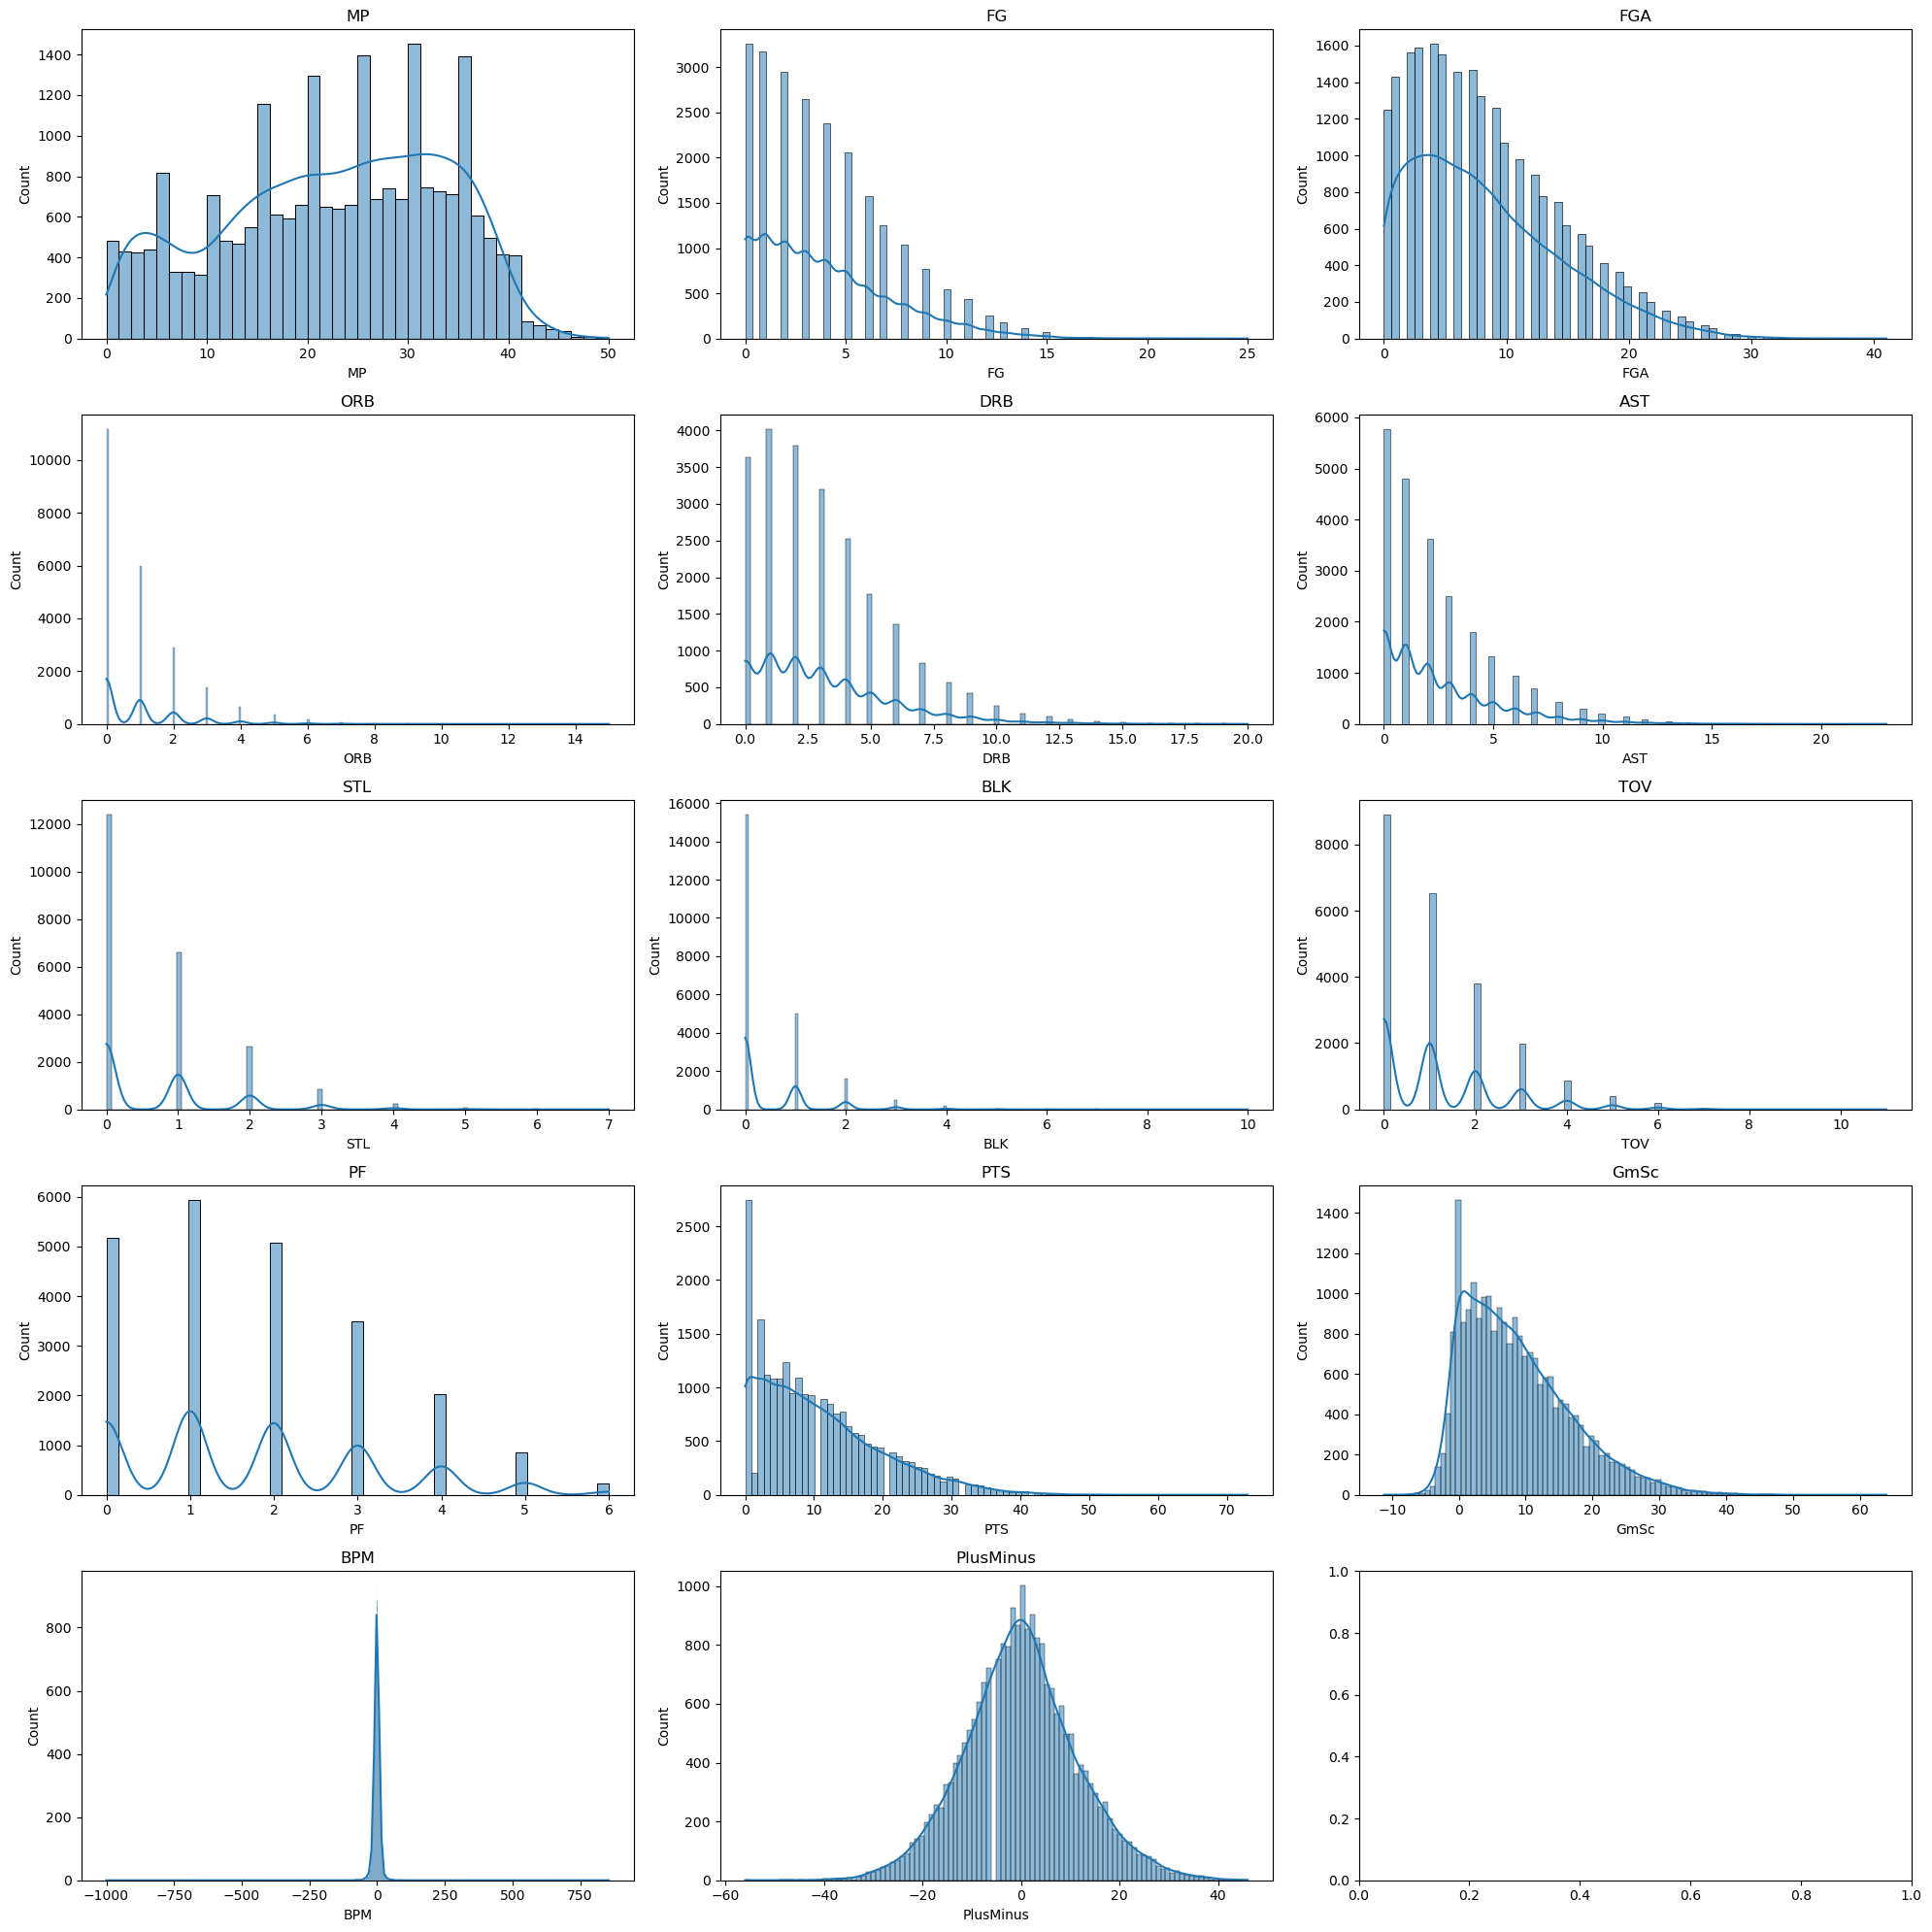

In [90]:
# List of numerical columns
numerical_columns = ['MP', 'FG', 'FGA', 'ORB',
                     'DRB', 'AST', 'STL', 'BLK',
                     'TOV', 'PF', 'PTS', 'GmSc',
                     'BPM', 'PlusMinus']

# Set up subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
axes = axes.flatten()

# Plot distributions
for i, col in enumerate(numerical_columns):
    sns.histplot(nba_df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

# Adjust layout
plt.tight_layout()
plt.show()

### Model Training

---



The model training section utilizes Ridge regression, summarized through these key steps:

**Step 1**: Split the data into **training** and **holdout test** sets for training and validation.

**Step 2**: Perform Ridge regression on the **training data** by standardizing features and identifying the optimal **regularization parameter** (alpha) via cross-validation with **RidgeCV**.

**Step 3**: Use **cross_val_score** to conduct cross-validation on the full training dataset for model evaluation using the chosen alpha value.

**Step 4**: Assess the model on the **holdout test** set for an unbiased performance estimate.

**Step 5**: For deployment or further predictions, retrain the model on the **entire dataset**, applying the optimal alpha.

In [91]:
# Split data into training and holdout set
X = nba_df.drop(columns='PTS')
y = nba_df['PTS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
# Create a pipeline that standardizes, then runs RidgeCV
ridge_pipeline = Pipeline([
    ('ridge_scaler', StandardScaler()),
    ('ridge_cv', RidgeCV(cv=5))
])

# Fit the model to the training data
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ridge_scaler', StandardScaler()),
                ('ridge_cv', RidgeCV(cv=5))])

In [93]:
# Extract the Ridge object from the pipeline
ridgecv_model = ridge_pipeline.named_steps['ridge_cv']

# Get best alpha value
ridgecv_model.alpha_

0.1

In [94]:
# Step 3: Evaluate the Model with Cross-Validation
ridge_cv_scores = cross_val_score(ridge_pipeline, X_train, y_train, cv=5)

# Print R2 value for each fold from training set
for score in ridge_cv_scores:
  print(score)

0.9989918254993835
0.9989074440680952
0.9988667056300331
0.9988748965549579
0.9989001523483423


In [95]:
# Fit model on training data using chosen alpha value and test it on holdout set
ridge_final_pipeline = Pipeline([('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=ridgecv_model.alpha_))
])

ridge_final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.1))])

In [96]:
# Step 4: Evaluate on Holdout Test Set
ridge_test_score = ridge_final_pipeline.score(X_test, y_test)

# R2 value for test set
print(ridge_test_score)

0.9987896447363593


In [97]:
ridge_final_pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.1))])

### Bayesian Inference

- **Personalized Priors**: The priors are personalized based on the player’s historical performance data.
- **Likelihoods from Recent Games**: Likelihoods are specifically derived from the most recent (5) games, rather than the entire historical dataset. This recent data provides a relevant snapshot of the player’s current form and condition.
- **Sampling and Updating Predictions**: The function performs sampling from the defined distributions to compute the posterior, which in turn updates the predictions for the player’s future performance based on both the priors and the new evidence from recent games.

In [99]:
def bayesian_inference(player_name, data):
    # Define the model
    model = pm.Model()
    
    # Specific player you want to focus on
    specific_player_column = f'Player_{player_name}'
    
    # Filter the data for the specific player using their one-hot encoded column
    # Assuming one-hot encoded columns contain binary values
    player_data = nba_df[nba_df[specific_player_column] == 1]
    
    # Use only the past 5 games for likelihood
    recent_games_data = player_data.tail(5)
    
    with model:
        # Dictionary to store the posterior estimates
        posteriors = {}
    
        # Loop through each numerical column
        for col in numerical_columns:
            # Define a normal prior using only data for the specific player
            mu_prior = pm.Normal(f'{col}_mu', mu=player_data[col].mean(), sigma=player_data[col].std())
    
            # Define a normal likelihood using only the past 5 games data
            observed = pm.Normal(f'{col}_observed', mu=mu_prior, sigma=player_data[col].std(), observed=recent_games_data[col])
            
            # Store the mu_prior in the dictionary to access later
            posteriors[col] = mu_prior
        
        # Perform sampling using NUTS
        trace = pm.sample(2000, tune=1000)

        # Calculate the mean of the posterior distribution for each numerical column
        # Update the new_row columns based on the mean of each posterior distribution
        for col in numerical_columns:
            # Calculate the mean of the posterior distribution for the current column
            mean_value = trace.posterior[f'{col}_mu'].mean().values
            
            # Update the corresponding column in new_row
            data[col] = mean_value
            
        return data

### Predictions on Future Data

Predictions are done in four steps:
- **Step 1**: Consider the player,  the opponent and home or away game
- **Step 2**: Consider the player’s overall season stats up until the current date and last 5 recent games
- **Step 3**: Obtain the player’s stats for the upcoming game
- **Step 4**: Use the mean for each of these values and use our regression model to make predictions

In [136]:
player = 'Stephen Curry'
opp = 'MIA'

# Create a new DataFrame initialized with zeros, with 1 row and the same columns as nba_df
new_df = pd.DataFrame(np.zeros((1, len(nba_df.columns))),
                      columns=nba_df.columns)

# Access the first row of the DataFrame using .iloc
new_row = nba_df.iloc[0]

# Set 'Away', 'Result', and 'GS' columns to 1
new_row['Away'] = 1
new_row['Result'] = 1
new_row['GS'] = 1

# Set all columns starting with "Player_" to 0, except "Player_{player}" to 1
for col in nba_df.columns:
    if col.startswith('Player_'):
        if col == f'Player_{player}':
            new_row[col] = 1
            break

# Set all columns starting with "Opp_" to 0, except "Opp_HOU" to 1
for col in nba_df.columns:
    if col.startswith('Opp_'):
        if col == f'Opp_{opp}':
            new_row[col] = 1
            break

new_df.iloc[0] = bayesian_inference(player, new_row)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [MP_mu, FG_mu, FGA_mu, ORB_mu, DRB_mu, AST_mu, STL_mu, BLK_mu, TOV_mu, PF_mu, PTS_mu, GmSc_mu, BPM_mu, PlusMinus_mu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


In [138]:
pts_scored = ridge_final_pipeline.predict(new_df.drop(columns='PTS'))
print(f"{player} @ {opp} on 26th March:", np.floor(pts_scored))

Stephen Curry @ MIA on 26th March: [25.]
